In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
from dotenv import load_dotenv
import os

env_path = '../../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
today

datetime.datetime(2024, 11, 11, 12, 57, 47, 497111)

In [3]:
project = hopsworks.login(project='AMomozZz')
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163416
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="aq_xgboost_model",
    version=1,
)
weather_fg = fs.get_feature_group(
    name='new_w',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='new_aq',
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.554791E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
batch_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by=['date'], ascending=True, ignore_index=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday
0,2024-11-12 00:00:00+00:00,15.950000,0.0,9.178235,64.440094,shanghai,63.0
1,2024-11-13 00:00:00+00:00,16.500000,0.0,10.495713,95.906044,shanghai,NaN
2,2024-11-14 00:00:00+00:00,19.700001,0.0,7.636753,135.000107,shanghai,NaN
3,2024-11-15 00:00:00+00:00,19.549999,0.2,8.557102,75.379089,shanghai,NaN
4,2024-11-16 00:00:00+00:00,19.450001,0.0,7.754637,68.198532,shanghai,NaN
5,2024-11-17 00:00:00+00:00,15.950000,0.0,26.552288,12.528798,shanghai,NaN
6,2024-11-18 00:00:00+00:00,12.500000,0.0,16.781561,22.714453,shanghai,NaN
7,2024-11-19 00:00:00+00:00,12.700000,0.0,12.303366,20.556128,shanghai,NaN
8,2024-11-20 00:00:00+00:00,13.500000,0.0,8.699793,65.556061,shanghai,NaN


In [7]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_yesterday"]])

batch_data['predicted_pm25'] = None
batch_data.at[0, 'predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data.iloc[[0]][['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pm25_yesterday']]
)[0]

for i in range(1, len(batch_data)):
    batch_data.at[i, 'pm25_yesterday'] = batch_data.at[i-1, 'predicted_pm25']
    batch_data.at[i, 'predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data.iloc[[i]][['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pm25_yesterday']]
    )[0]

display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25
0,2024-11-12 00:00:00+00:00,15.950000,0.0,9.178235,64.440094,shanghai,63.000000,64.213699
1,2024-11-13 00:00:00+00:00,16.500000,0.0,10.495713,95.906044,shanghai,64.213699,75.564171
2,2024-11-14 00:00:00+00:00,19.700001,0.0,7.636753,135.000107,shanghai,75.564171,85.248894
3,2024-11-15 00:00:00+00:00,19.549999,0.2,8.557102,75.379089,shanghai,85.248894,105.558327
4,2024-11-16 00:00:00+00:00,19.450001,0.0,7.754637,68.198532,shanghai,105.558327,110.008629
5,2024-11-17 00:00:00+00:00,15.950000,0.0,26.552288,12.528798,shanghai,110.008629,87.083916
6,2024-11-18 00:00:00+00:00,12.500000,0.0,16.781561,22.714453,shanghai,87.083916,96.932098
7,2024-11-19 00:00:00+00:00,12.700000,0.0,12.303366,20.556128,shanghai,96.932098,96.695328
8,2024-11-20 00:00:00+00:00,13.500000,0.0,8.699793,65.556061,shanghai,96.695328,106.891685


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_yesterday               9 non-null      float32            
 7   predicted_pm25               9 non-null      object             
dtypes: datetime64[us, UTC](1), float32(5), object(2)
memory usage: 528.0+ bytes


In [8]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-12 00:00:00+00:00,15.950000,0.0,9.178235,64.440094,shanghai,63.000000,64.213699,jinganjiancezhan,china,1
1,2024-11-13 00:00:00+00:00,16.500000,0.0,10.495713,95.906044,shanghai,64.213699,75.564171,jinganjiancezhan,china,2
2,2024-11-14 00:00:00+00:00,19.700001,0.0,7.636753,135.000107,shanghai,75.564171,85.248894,jinganjiancezhan,china,3
3,2024-11-15 00:00:00+00:00,19.549999,0.2,8.557102,75.379089,shanghai,85.248894,105.558327,jinganjiancezhan,china,4
4,2024-11-16 00:00:00+00:00,19.450001,0.0,7.754637,68.198532,shanghai,105.558327,110.008629,jinganjiancezhan,china,5
5,2024-11-17 00:00:00+00:00,15.950000,0.0,26.552288,12.528798,shanghai,110.008629,87.083916,jinganjiancezhan,china,6
6,2024-11-18 00:00:00+00:00,12.500000,0.0,16.781561,22.714453,shanghai,87.083916,96.932098,jinganjiancezhan,china,7
7,2024-11-19 00:00:00+00:00,12.700000,0.0,12.303366,20.556128,shanghai,96.932098,96.695328,jinganjiancezhan,china,8
8,2024-11-20 00:00:00+00:00,13.500000,0.0,8.699793,65.556061,shanghai,96.695328,106.891685,jinganjiancezhan,china,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_yesterday               9 non-null      float32            
 7   predicted_pm25               9 non-null      object             
 8   street                       9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64    

2024-11-11 12:57:57,298 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



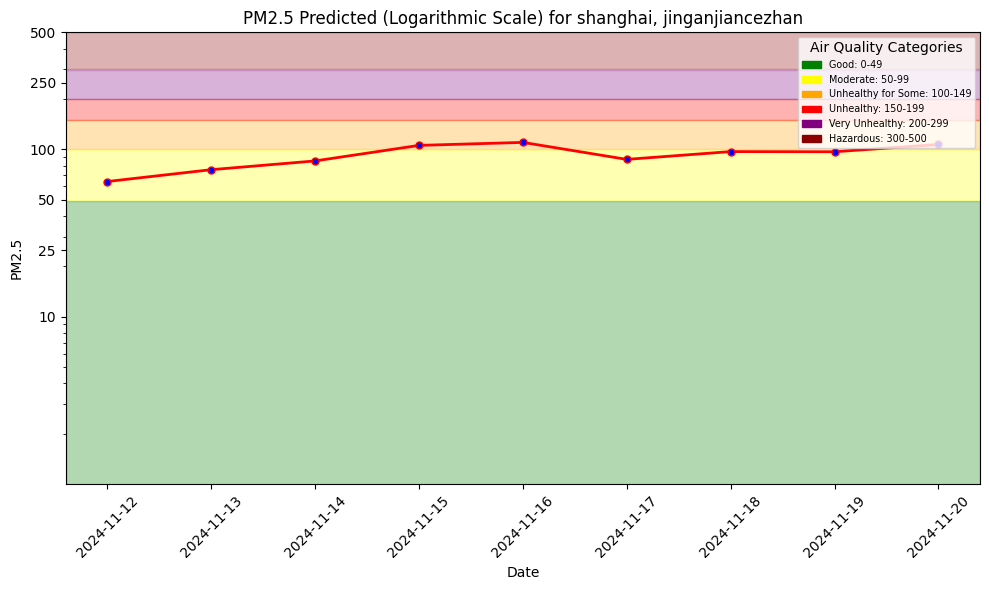

In [9]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [10]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [11]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163416/jobs/named/aq_predictions_3_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1baf151b910>, None)

In [12]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


In [13]:
display(monitor_fg.read().sort_values(by=['date'], ascending=True))
display(monitoring_df)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.56s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25,street,country,days_before_forecast_day
9,2024-11-10 00:00:00+00:00,15.400000,0.0,13.320000,360.000000,shanghai,46.000000,78.574898,jinganjiancezhan,china,1
8,2024-11-11 00:00:00+00:00,15.250000,0.0,10.195057,42.137531,shanghai,127.000000,103.868004,jinganjiancezhan,china,1
4,2024-11-12 00:00:00+00:00,15.550000,0.0,9.339208,62.447273,shanghai,103.868004,109.765266,jinganjiancezhan,china,2
13,2024-11-12 00:00:00+00:00,15.950000,0.0,9.178235,64.440094,shanghai,63.000000,64.213699,jinganjiancezhan,china,1
3,2024-11-13 00:00:00+00:00,16.250000,0.0,11.013882,101.309898,shanghai,109.765266,136.029587,jinganjiancezhan,china,3
15,2024-11-13 00:00:00+00:00,16.500000,0.0,10.495713,95.906044,shanghai,64.213699,75.564171,jinganjiancezhan,china,2
2,2024-11-14 00:00:00+00:00,20.150000,0.0,9.693296,148.671371,shanghai,136.029587,117.728584,jinganjiancezhan,china,4
14,2024-11-14 00:00:00+00:00,19.700001,0.0,7.636753,135.000107,shanghai,75.564171,85.248894,jinganjiancezhan,china,3
7,2024-11-15 00:00:00+00:00,20.450001,0.1,5.191994,56.309914,shanghai,117.728584,142.418839,jinganjiancezhan,china,5
17,2024-11-15 00:00:00+00:00,19.549999,0.2,8.557102,75.379089,shanghai,85.248894,105.558327,jinganjiancezhan,china,4


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_yesterday,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-11 00:00:00+00:00,15.25,0.0,10.195057,42.137531,shanghai,127.0,103.868004,jinganjiancezhan,china,1
1,2024-11-10 00:00:00+00:00,15.40,0.0,13.320000,360.000000,shanghai,46.0,78.574898,jinganjiancezhan,china,1
2,2024-11-12 00:00:00+00:00,15.95,0.0,9.178235,64.440094,shanghai,63.0,64.213699,jinganjiancezhan,china,1


In [14]:
air_quality_df = air_quality_fg.read()
air_quality_fg.read().sort_values(by=['date'], ascending=True).tail(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,pm25,country,city,street,url
1370,2024-11-07 00:00:00+00:00,35.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3121,2024-11-08 00:00:00+00:00,55.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
2555,2024-11-09 00:00:00+00:00,46.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3039,2024-11-10 00:00:00+00:00,119.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3952,2024-11-11 00:00:00+00:00,63.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486


In [15]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-10 00:00:00+00:00,78.574898,119.0
0,2024-11-11 00:00:00+00:00,103.868004,63.0


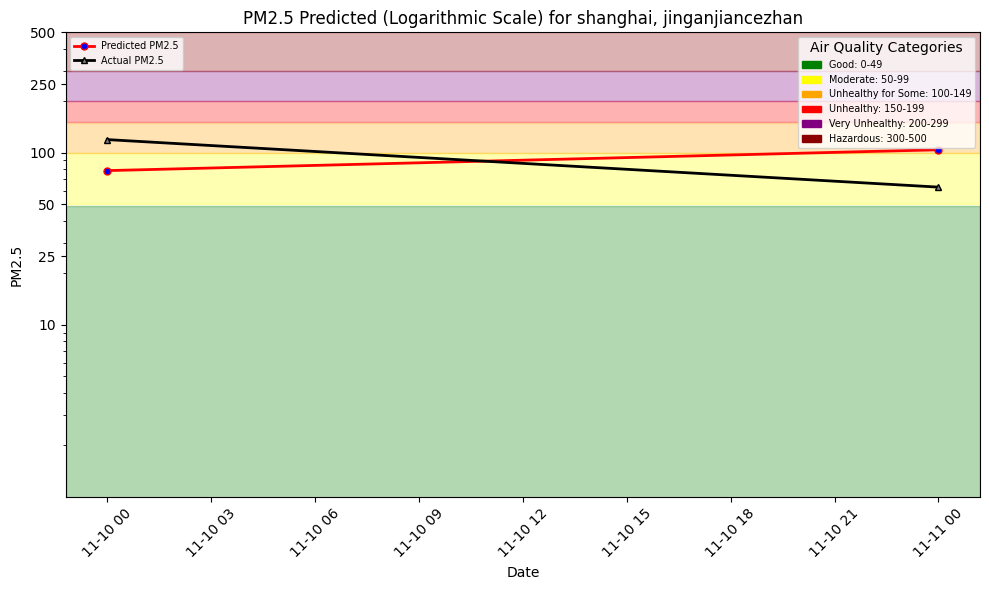

In [16]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()